In [1]:
import pandas as pd
import numpy as np

import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torchmetrics
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Cleaning

Remove NaN values and remove irrelevant columns

In [5]:
df = pd.read_csv('penguins_size.csv')

# Assumption: sex plays no role in the species of the animal

df.drop('sex', axis = 1, inplace = True)
df.dropna(axis = 0, inplace = True)

df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0


## Exploratory data analysis

Basic information on the data 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, 0 to 343
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            342 non-null    object 
 1   island             342 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
dtypes: float64(4), object(2)
memory usage: 18.7+ KB


In [9]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


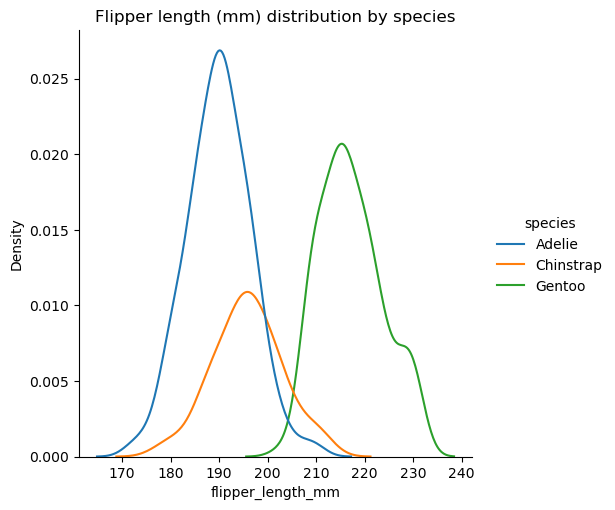

In [10]:
sns.displot(data=df, x="flipper_length_mm", hue="species", kind="kde")
plt.title('Flipper length (mm) distribution by species')
plt.show()

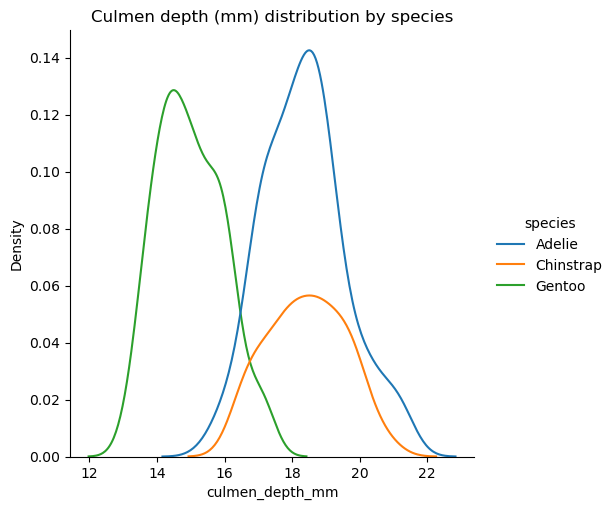

In [11]:
sns.displot(data=df, x="culmen_depth_mm", hue="species", kind="kde")
plt.title('Culmen depth (mm) distribution by species')
plt.show()

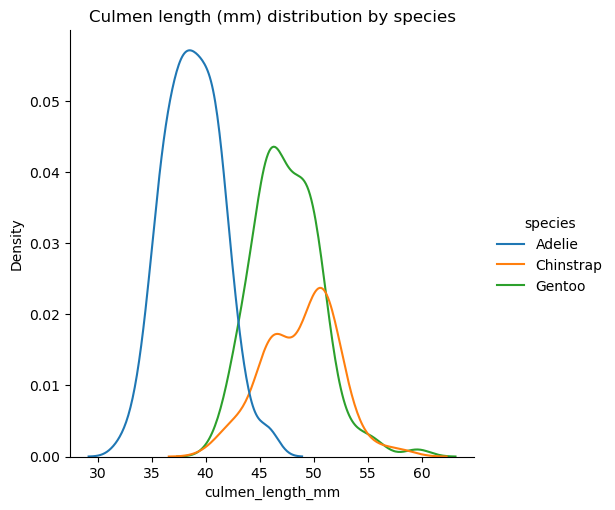

In [12]:
sns.displot(data=df, x="culmen_length_mm", hue="species", kind="kde")
plt.title('Culmen length (mm) distribution by species')
plt.show()

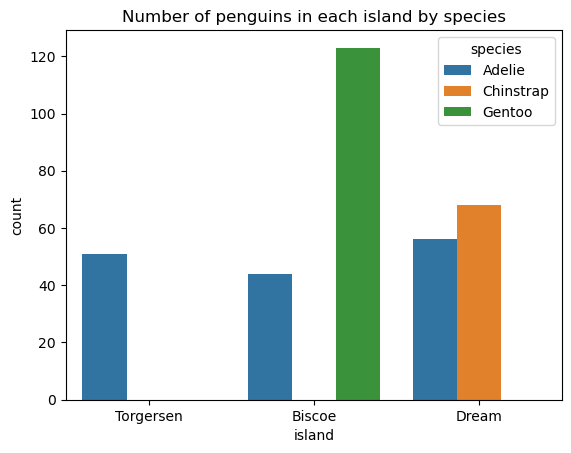

In [13]:
sns.countplot(x="island",hue = 'species', data=df) 
plt.title('Number of penguins in each island by species')
plt.show()

## Data adjustment

Turn categorical data into numerical data

In [16]:
df['island'].replace(['Torgersen', 'Biscoe', 'Dream'], [0, 1, 2], inplace=True)
df['species'].replace(['Adelie', 'Chinstrap', 'Gentoo'], [0, 1, 2], inplace=True)

In [17]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,0,0,39.1,18.7,181.0,3750.0
1,0,0,39.5,17.4,186.0,3800.0
2,0,0,40.3,18.0,195.0,3250.0
4,0,0,36.7,19.3,193.0,3450.0
5,0,0,39.3,20.6,190.0,3650.0


## Data preparation

In [19]:
np_features = df.to_numpy()[:, 1:]
np_target = df.to_numpy()[:, 0]

# one-hot encodings for the target
np_target = np.array([F.one_hot(torch.tensor(int(i)), num_classes = 3) for i in np_target])

In [20]:
np_features_train, np_features_val, np_target_train, np_target_val  = train_test_split(np_features, np_target, test_size=0.1, train_size=0.9)

In [21]:
torch_features_train = torch.from_numpy(np_features_train).float()
torch_target_train = torch.from_numpy(np_target_train).float()

torch_features_val = torch.from_numpy(np_features_val).float()
torch_target_val = torch.from_numpy(np_target_val).float()

# Create a TensorDataset from two tensors
dataset_train = TensorDataset(torch_features_train, torch_target_train)
dataset_val = TensorDataset(torch_features_val, torch_target_val)

In [22]:
train_dataloader = DataLoader(dataset_train, batch_size = 8, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size = 4, shuffle=True)

In [23]:
next(iter(train_dataloader))

[tensor([[1.0000e+00, 3.6400e+01, 1.7100e+01, 1.8400e+02, 2.8500e+03],
         [1.0000e+00, 4.5800e+01, 1.4200e+01, 2.1900e+02, 4.7000e+03],
         [0.0000e+00, 3.6700e+01, 1.9300e+01, 1.9300e+02, 3.4500e+03],
         [2.0000e+00, 3.7300e+01, 1.7800e+01, 1.9100e+02, 3.3500e+03],
         [1.0000e+00, 4.5500e+01, 1.3700e+01, 2.1400e+02, 4.6500e+03],
         [2.0000e+00, 5.1300e+01, 1.9900e+01, 1.9800e+02, 3.7000e+03],
         [2.0000e+00, 3.5600e+01, 1.7500e+01, 1.9100e+02, 3.1750e+03],
         [1.0000e+00, 4.3400e+01, 1.4400e+01, 2.1800e+02, 4.6000e+03]]),
 tensor([[1., 0., 0.],
         [0., 0., 1.],
         [1., 0., 0.],
         [1., 0., 0.],
         [0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.],
         [0., 0., 1.]])]

## Model

In [54]:
class PenguinModel(nn.Module):
    def __init__(self):
        super(PenguinModel, self).__init__()
        # Define the three linear layers
        self.fc1 = nn.Linear(5, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 3)
        self.bn1 = nn.BatchNorm1d(8)
        self.bn2 = nn.BatchNorm1d(16)
        
    def forward(self, x):
        # Pass x through linear layers adding activations
        x = nn.functional.relu(self.bn1(self.fc1(x)))
        x = nn.functional.relu(self.bn2(self.fc2(x)))
        x = nn.functional.softmax(self.fc3(x))
        return x

In [56]:
penguin = PenguinModel()

In [58]:
optimizer = optim.Adam(penguin.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [60]:
metric = torchmetrics.Accuracy(task="multiclass", num_classes=3)
metric2 = torchmetrics.Accuracy(task="multiclass", num_classes=3)

## Training & Evaluation

In [63]:
# Loop over the number of epochs and the dataloader

num_epochs = 5

for i in range(num_epochs):
    running_loss = 0
    
    for data in train_dataloader:
        # Set the gradients to zero
        optimizer.zero_grad()
        # Run a forward pass
        feature, target = data
        prediction = penguin(feature)    
        # Calculate the loss
        loss = criterion(prediction, target)    
        # Compute the gradients
        loss.backward()
        # Update the model's parameters
        optimizer.step()
    
        running_loss += loss.item()
        acc = metric(prediction.softmax(dim=-1), target.argmax(dim=-1))
        
    acc = metric.compute()
    metric.reset()

    # Set the model to evaluation mode
    penguin.eval()
    validation_loss = 0.0
    
    with torch.no_grad():
      
      for data in val_dataloader:
        
          feature, target = data
          prediction = penguin(feature)
          loss = criterion(prediction, target)
          acc2 = metric(prediction.softmax(dim=-1), target.argmax(dim=-1))
          
          # Sum the current loss to the validation_loss variable
          validation_loss += loss.item()

    acc2 = metric.compute()
        
    print(f'Epoch {i}: Loss: {running_loss}, Accuracy: {acc} | Validation Loss: {validation_loss}, Validation Accuracy: {acc2}')
    metric.reset()

Epoch 0: Loss: 40.31387734413147, Accuracy: 0.5407165884971619 | Validation Loss: 9.464992761611938, Validation Accuracy: 0.4571428596973419
Epoch 1: Loss: 36.7186433672905, Accuracy: 0.6677524447441101 | Validation Loss: 8.356021583080292, Validation Accuracy: 0.6000000238418579
Epoch 2: Loss: 33.12397563457489, Accuracy: 0.7394136786460876 | Validation Loss: 8.175994455814362, Validation Accuracy: 0.6571428775787354
Epoch 3: Loss: 32.04236966371536, Accuracy: 0.7394136786460876 | Validation Loss: 8.049848139286041, Validation Accuracy: 0.6285714507102966
Epoch 4: Loss: 31.665494084358215, Accuracy: 0.7491856813430786 | Validation Loss: 7.955517292022705, Validation Accuracy: 0.6571428775787354


Note: not entirely interested in making the model good, just programming the model process for future reference